# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import sys
import json

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines

import jsonlines
import numpy as np
from collections import defaultdict

## I. N-Gram Language Modeling

#### Utilities

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [3]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [4]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [38]:
class NGramInterpolation(object):
    def __init__(self, n, alpha, gamma, vsize):
        self.n = n
#         self.lam = lam
        self.alpha = alpha
        self.gamma = gamma
        self.vsize = vsize
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
    
    def estimate(self, sequences):
        for sequence in sequences:
            for n in range(1, self.n+1):
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        
        if self.total[prefix] > 0:
            prob = (self.count[prefix][word] / self.total[prefix]) * self.alpha
        else:
            prob = self.gamma * self.ngram_prob(ngram[1:])
        
#         if len(ngram) >= 2:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*self.ngram_prob(ngram[1:])
#         elif len(ngram) == 1:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*1./self.vsize
        return prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [36]:
n = 2
for lambda_ in np.linspace(0.1,1,10):
    lm2 = NGramInterpolation(n=n, lam=lambda_, vsize=len(vocab)+1)  # +1 is for <eos>
    lm2.estimate(datasets['train'])
    print("Baseline (Interpolation, n=%d, lambda=%.4f)) Train Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['train'])))
    print("Baseline (Interpolation, n=%d, lambda=%.4f)) Valid Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['valid'])))

When lambda = 0.1
Baseline (Interpolation, n=2, delta=0.1000)) Train Perplexity: 517.683


ZeroDivisionError: float division by zero

## II. Neural Language Modeling with a Recurrent Neural Network

In [10]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [49]:
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm

In [50]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [51]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [101]:
wikitext_dict = Dictionary(datasets, include_valid=True)

# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 8464/8464 [00:22<00:00, 375.32it/s]


The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [102]:
# Construct Datasets
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [111]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = wikitext_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [104]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 46311.74it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [124]:
wikitext_loaders = {}
batch_size = 128
for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

### II.1 LSTM and Hyper-Parameters

In [125]:
# making a FFNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [153]:
import torch.nn as nn

class RnnLM(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super(RnnLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        # create each LM part here 
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.rnn = nn.RNN(self.embed_dim, self.hidden_dim, self.num_layers, dropout=self.p, batch_first=self.batch_first)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        print(type(embeddings))
        print(embeddings.shape)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [154]:
class LstmLM(torch.nn.Module):
    def __init__(self, options):
        '''
        params:
            @options: dictionary of model parameters
        '''
        super(LstmLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.num_layers, batch_first=self.batch_first, dropout=self.p) # lstm takes word embeddings as inputs and outputs hidden states (dim=hidden_dinm)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size) # linear layer maps from hidden states to word space

    def forward(self, encoded_input_sequence):
        '''
        Forwrad method process the input from token ids to logits
        params:
            @inp: input sentence
        '''
        embedded = self.lookup(encoded_input_sequence)
        lstm_out, _ = self.lstm(embedded)
        logits = self.projection(lstm_out)
        
        return logits

In [155]:
def compute_predictions(logits):
    """Transforms logits to probabilities and finds the most probable tags(words)."""
    # Create softmax (F.softmax) function
    softmax_output = F.softmax(logits, axis=-1)
    predictions = torch.argmax(softmax_output, axis=-1)
    return predictions

In [156]:
# creating a model, criterion and optimizer
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

# define model parameters -- options
embed_dim = 256
hidden_dim = 512
num_layers = 3
dropout = 0.3
options = {
    'vocab_size': len(wikitext_dict),
    'embed_dim': embed_dim,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': True
}

In [157]:
model_rnn = RnnLM(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))
model_rnn_params = [p for p in model_rnn.parameters() if p.requires_grad]
rnn_optimizer = optim.SGD(model_rnn_params, lr=0.001, momentum=0.999)

In [158]:
model_rnn

RnnLM(
  (lookup): Embedding(33181, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33181, bias=True)
)

In [159]:
model_lstm = LstmLM(options).to(current_device)
model_lstm_params = [p for p in model_lstm.parameters() if p.requires_grad]
lstm_optimizer = optim.SGD(model_lstm_params, lr=0.001, momentum=0.999)

In [160]:
model_lstm

LstmLM(
  (lookup): Embedding(33181, 256, padding_idx=2)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33181, bias=True)
)

#### Results (LSTM vs. Baseline)

In [161]:
# now we make same training loop, now with dataset and the model
def train_model(model, model_name, num_epochs, loaders, optimizer):
    print("Training {}:",format(model_name))
    plot_cache = []
    for epoch in range(num_epochs):
        avg_loss=0
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            # compute loss
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            # back-propogation
            loss.backward()
            optimizer.step()
            train_log_cache.append(loss.item()) # store training loss

            if i % 100 == 0:
                avg_train_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_train_loss, prec=4))
                train_log_cache = []

        #do validation
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)
                # compute loss
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item()) # store validation loss
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch, avg_val_loss, prec=4))

        plot_cache.append((avg_train_loss, avg_val_loss))
        
    print('Finished training')
    return

In [162]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(losses):
    epochs = np.array(list(range(len(losses))))
    fig = plt.figure(figsize = (10,5))
    axes = fig.subplots(nrows=1, ncols=2)
    # plot losses
    axes[0].plot(epochs, [i[0] for i in losses], label='Train loss')
    axes[0].set_title("Training loss over time")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Train Losses")
    # plot training & validation accuracy
    axes[1].plot(epochs, [i[1] for i in losses], label='Val loss')
    axes[1].set_title("Validation loss over time")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Val Losses")

In [ ]:
train_model(model_rnn, "RNN LM", 100, wikitext_loaders, rnn_optimizer)

Training {}: RNN LM
<class 'torch.Tensor'>
torch.Size([128, 72, 256])
Step 0 avg train loss = 10.4282
<class 'torch.Tensor'>
torch.Size([128, 85, 256])
<class 'torch.Tensor'>
torch.Size([128, 56, 256])
<class 'torch.Tensor'>
torch.Size([128, 72, 256])


#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [12]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


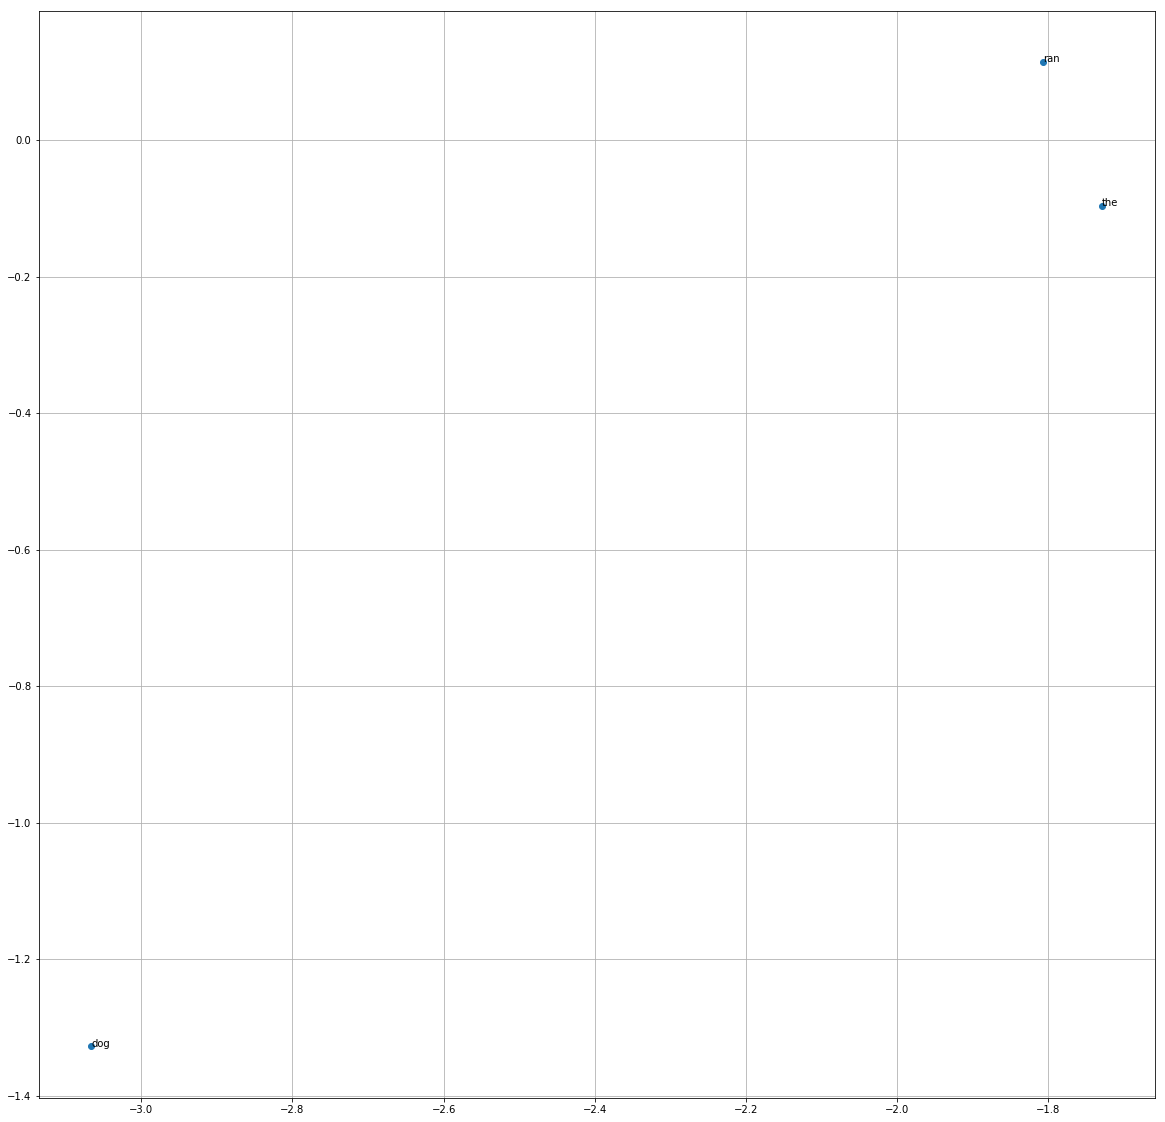

In [14]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

#### II.2.3 Projection Layer

### II.3 Scoring

#### II.3.2 Highest and Lowest scoring sequences

#### II.3.3 Modified sequences

### II.4 Sampling

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples